In [1]:
import seaborn as sns
from pandas import DataFrame
from reservoirpy.nodes import ESN
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler

from main import Estimator, get_dataframe, iterate_mixedml, loop_mixedml

In [2]:
X_LABELS = ["x2_x5", "x4_x7", "x6_x8"]

# the paper says "y_fixed" for "y fixed effects"
# but it can be understood as "y not changing"
# so I call it "y_fe"
Y_LABEL = "y_mixed_obs"  # the values are fixed
Y_LABEL_FE = Y_LABEL + "_fixed"  # the value are not fixed

#
SERIES = "individus"
TSTEPS = "temps"

In [3]:
data = get_dataframe("../../data/synthetic_bph_1/01_test.csv")
data = data[data[SERIES] < 20]
data = data[[SERIES, TSTEPS] + X_LABELS + [Y_LABEL]]
data[X_LABELS + [Y_LABEL]] = RobustScaler().fit_transform(data[X_LABELS + [Y_LABEL]])

In [4]:
N_series = len(data[SERIES].unique())
N_tsteps = len(data[TSTEPS].unique())

In [5]:
data

,individus,temps,x2_x5,x4_x7,x6_x8,y_mixed_obs
0,1,0,-0.802429,-0.471798,0.0,-1.129335
1,1,1,-0.744390,-0.323000,0.0,-0.932142
2,1,2,-0.716285,-0.249475,0.0,-0.896724
3,1,3,-0.700024,-0.222418,0.0,-0.858849
4,1,4,-0.690015,-0.214187,0.0,-0.905740
...,...,...,...,...,...,...
489,19,21,0.030368,-0.211567,0.0,-0.074280
490,19,22,0.030368,-0.211567,0.0,-0.071697
491,19,23,0.030368,-0.211567,0.0,-0.044650
492,19,24,0.030368,-0.211567,0.0,0.031557


In [6]:
??iterate_mixedml

Signature:
iterate_mixedml(
    ml_fixed: main.Estimator,
    df_data: pandas.core.frame.DataFrame,
) -> tuple[sklearn.neural_network._multilayer_perceptron.MLPRegressor, pandas.core.frame.DataFrame, bool]
Docstring: <no docstring>
Source:   
def iterate_mixedml(
    ml_fixed: Estimator, df_data: DataFrame
) -> tuple[MLPRegressor, DataFrame, bool]:

    #### fitting the Machine Learning model
    X = df_data[X_LABELS]
    y = df_data[Y_LABEL_FE]
    # we train ml_fixed by ignoring cluster effects (with the target y)
    ml_fixed.fit(X, y)
    # to get an estimate of y_fixed
    y_fixed = ml_fixed.predict(X)

    #### fitting the Mixed Effect model
    # based on e_fixed
    # !!! l'erreur était là (j'utilisais "y- y_fixed")
    df_data["e_fixed"] = df_data[Y_LABEL] - y_fixed
    df_data.to_csv("ml_pred.csv", index=False)
    # we estimate u
    call(["Rscript", "random_effects_fitting.R"])
    random_preds = read_csv("random_preds.csv")
    y_random = random_preds["pred_ss"].to_numpy()

In [7]:
%cat random_effects_fitting.R

library(lcmm)

data <- read.csv2('ml_pred.csv', sep = ',', dec = '.')
data$x6_x8 <- as.numeric(data$x6_x8)


data$individus <- as.numeric(data$individus)
random_hlme <- hlme(
  e_fixed ~ 1,
  random = ~  x2_x5 + x4_x7 + x6_x8,
  # cor = AR(temps) ou BM(temps)
  idiag = TRUE,
  data = data,
  subject = 'individus',
)

write.table(
  random_hlme$pred,
  "random_preds.csv",
  sep = ",",
  dec = ".",
  row.names = FALSE
)

saveRDS(random_hlme, 'random_hlme.Rds')


In [9]:
model = Estimator(ESN(units=50), reshape=True, N_series=N_series, N_tsteps=N_tsteps)

MAX_ITER = 500
results = loop_mixedml(model, data, n_iter_improve=20, max_iter=MAX_ITER)

mixedML step #00: 7.089391e-02 (best)
mixedML step #01: 1.422297e-02 (best)
mixedML step #02: 1.203376e-02 (best)
mixedML step #03: 1.169791e-02 (best)
mixedML step #04: 1.147046e-02 (best)
mixedML step #05: 1.129634e-02 (best)
mixedML step #06: 1.115159e-02 (best)
mixedML step #07: 1.103000e-02 (best)
mixedML step #08: 1.092876e-02 (best)
mixedML step #09: 1.084528e-02 (best)
mixedML step #10: 1.077699e-02 (best)
mixedML step #11: 1.072153e-02 (best)
mixedML step #12: 1.067683e-02 (best)
mixedML step #13: 1.064116e-02 (best)
mixedML step #14: 1.061300e-02 (best)
mixedML step #15: 1.059113e-02 (best)
mixedML step #16: 1.057448e-02 (best)
mixedML step #17: 1.056220e-02 (best)
mixedML step #18: 1.055355e-02 (best)
mixedML step #19: 1.054792e-02 (best)
mixedML step #20: 1.054480e-02 (best)
mixedML step #21: 1.054376e-02 (best)
mixedML step #22: 1.054444e-02
mixedML step #23: 1.054655e-02
mixedML step #24: 1.054985e-02
mixedML step #25: 1.055410e-02
mixedML step #26: 1.055915e-02
mixedML s

<Axes: >

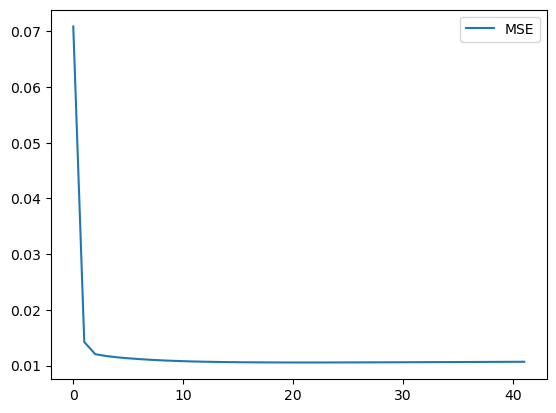

In [10]:
sns.lineplot(DataFrame(results, columns=["MSE"]))

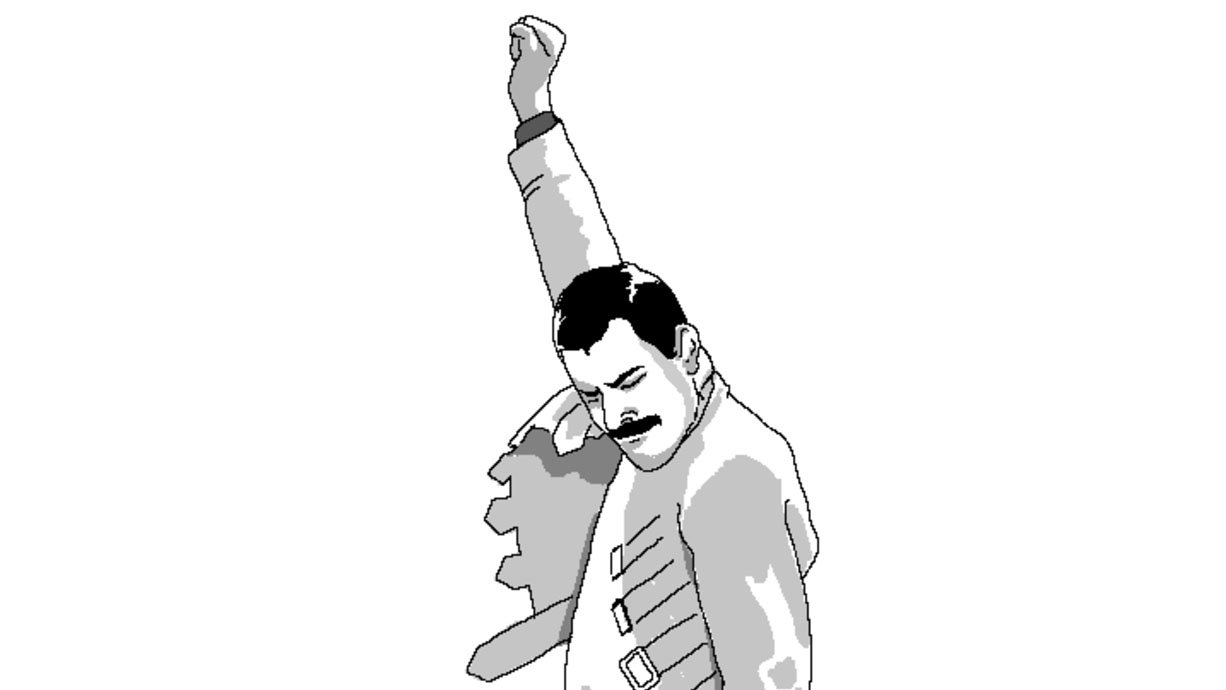